# Turkish News

## Import Libraries

In [108]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report

from src.utils import get_project_config
from src.utils import missing_values
import time
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [80]:
%matplotlib inline
sns.set(style='whitegrid')

In [78]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

#### Set Path and Constant Values

In [4]:
# Set Constants
ROOT_PATH = os.getcwd()
CFG_PATH = os.path.join(ROOT_PATH, 'cfg')
DATA_PATH = os.path.join(ROOT_PATH, 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
EMBEDDING_DATA_PATH = os.path.join(DATA_PATH, 'embedding')

os.makedirs(RAW_DATA_PATH, exist_ok=True)
# os.makedirs(EMBEDDING_DATA_PATH, exist_ok=True)

### Embedding Models

In [37]:
embedding_models = [
    'sentence-transformers/all-MiniLM-L12-v2',
    "jinaai/jina-embeddings-v3",
    "intfloat/multilingual-e5-large-instruct",
    "BAAI/bge-m3",
    "thenlper/gte-large"
]

embedding_models_dict = {
    "All Mini LM L12 v2": "sentence-transformers/all-MiniLM-L12-v2",
    "Jina Embeddings v3": "jinaai/jina-embeddings-v3",
    "Int Float Multilingual E5 Large Instruct": "intfloat/multilingual-e5-large-instruct",
    "BAAI BGE M3": "BAAI/bge-m3",
    "Thenlper Gte Large" : "thenlper/gte-large"
}

## Import Dataset: Turkish News Datasets

In [43]:
df_news_data = pd.read_csv(os.path.join(RAW_DATA_PATH, "tr_news_data.csv.gz"), compression='gzip')

In [7]:
df_emb_data_1 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_sentence-transformers__all-MiniLM-L12-v2_embeddings.csv.gz"), compression='gzip')
df_emb_data_1.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [8]:
df_emb_data_2 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_jinaai__jina-embeddings-v3_embeddings.csv.gz"), compression='gzip')
df_emb_data_2.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [9]:
df_emb_data_3 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_intfloat__multilingual-e5-large-instruct_embeddings.csv.gz"), compression='gzip')
df_emb_data_3.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [10]:
df_emb_data_4 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_BAAI__bge-m3_embeddings.csv.gz"), compression='gzip')
df_emb_data_4.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [11]:
df_emb_data_5 = pd.read_csv(os.path.join(EMBEDDING_DATA_PATH, "news_thenlper__gte-large_embeddings.csv.gz"), compression='gzip')
df_emb_data_5.head(3)

,Ozet,Kategori,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,embedding_290,embedding_291,embeddi

In [40]:
print(f"Emb. Model Name: {embedding_models[0]} & Data Shape: {df_emb_data_1.shape}")
print(f"Emb. Model Name: {embedding_models[1]} & Data Shape: {df_emb_data_2.shape}")
print(f"Emb. Model Name: {embedding_models[2]} & Data Shape: {df_emb_data_3.shape}")
print(f"Emb. Model Name: {embedding_models[3]} & Data Shape: {df_emb_data_4.shape}")
print(f"Emb. Model Name: {embedding_models[4]} & Data Shape: {df_emb_data_5.shape}")

Emb. Model Name: sentence-transformers/all-MiniLM-L12-v2 & Data Shape: (7500, 386)
Emb. Model Name: jinaai/jina-embeddings-v3 & Data Shape: (7500, 1026)
Emb. Model Name: intfloat/multilingual-e5-large-instruct & Data Shape: (7500, 1026)
Emb. Model Name: BAAI/bge-m3 & Data Shape: (7500, 1026)
Emb. Model Name: thenlper/gte-large & Data Shape: (7500, 1026)


## Modelling

((7500, 1024), (7500,))

In [151]:
label_encoder = LabelEncoder()

df_emb_data_list = [df_emb_data_1, df_emb_data_2, df_emb_data_3, df_emb_data_4, df_emb_data_5]

for idx, df_emb_data in enumerate(df_emb_data_list):
    print(f"{idx+1} Embedding Data Shape: {df_emb_data.shape}")
    print("Target Unique Values:", df_emb_data['Kategori'].unique())

    feature_columns = [col for col in df_emb_data.columns if 'embedding_' in col]
    # print("Feature Columns:", feature_columns)
    
    X = df_emb_data[feature_columns].values
    # y = df_emb_data_1['Kategori'].values
    y_encoded = label_encoder.fit_transform(df_emb_data['Kategori'].values)
    y = y_encoded
    print(f"X Shape: {X.shape} & y Shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)
    print(f"X_Train Shape: {X_train.shape} & X_Test Shape: {X_test.shape} & Y_Train Shape: {y_train.shape} & Y_Test Shape: {y_test.shape}")
    
    X_train.shape, y_train.shape, X_test.shape, y_test.shape
    print("* " * 50)

1 Embedding Data Shape: (7500, 386)
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
X Shape: (7500, 384) & y Shape: (7500,)
X_Train Shape: (6500, 384) & X_Test Shape: (1000, 384) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
2 Embedding Data Shape: (7500, 1026)
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
X Shape: (7500, 1024) & y Shape: (7500,)
X_Train Shape: (6500, 1024) & X_Test Shape: (1000, 1024) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
3 Embedding Data Shape: (7500, 1026)
Target Unique Values: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']
X Shape: (7500, 1024) & y Shape: (7500,)
X_Train Shape: (6500, 1024) & X_Test Shape: (1000, 1024) & Y_Train Shape: (6500,) & Y_Test Shape: (1000,)
* * * * * * * * * * * * * * * * * * * * * * * * *

### Model 1: SVM Model

#### Encoding

In [112]:
print("Target Unique Values:", df_emb_data_1['Kategori'].unique())

# df_emb_data_1['Kategori'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_emb_data_1['Kategori'].values)

Kategori Benzersiz Degerler: ['Türkiye' 'Dünya' 'Spor' 'Gündem' 'Eğitim']


array([4, 0, 0, ..., 2, 3, 4])

#### Split Dataset

In [113]:
feature_columns = [col for col in df_emb_data_1.columns if 'embedding_' in col]
print("Feature Columns:", feature_columns)

X = df_emb_data_1[feature_columns].values
# y = df_emb_data_1['Kategori'].values
y = y_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000, random_state=42, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Feature Columns: ['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27', 'embedding_28', 'embedding_29', 'embedding_30', 'embedding_31', 'embedding_32', 'embedding_33', 'embedding_34', 'embedding_35', 'embedding_36', 'embedding_37', 'embedding_38', 'embedding_39', 'embedding_40', 'embedding_41', 'embedding_42', 'embedding_43', 'embedding_44', 'embedding_45', 'embedding_46', 'embedding_47', 'embedding_48', 'embedding_49', 'embedding_50', 'embedding_51', 'embedding_52', 'embedding_53', 'embedding_54', 'embedding_55', 'embedding_56', 'embedding_57', 'embedding_58', 'embedding_59', 'embedding_60', 'embedding_61', 

((6500, 384), (6500,), (1000, 384), (1000,))

#### K Fold Cross Validation

In [114]:
# K-fold Cross Validation Value 5, 10
k_fold_splits = 5

# Create K-fold object
kf = KFold(n_splits=k_fold_splits, shuffle=True, random_state=23)

#### SVM Classifier

In [120]:
# # SVM Hiperparametre Optimizasyonu (f1)

# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# # SVM Classifier
# svm_model = SVC()
# svm_params = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': ['scale', 'auto']
# }

# # Grid Search
# svm_grid = GridSearchCV(estimator=svm_model, param_grid=svm_params, scoring='f1', cv=3)
# svm_grid.fit(X_train, y_train)

# # En iyi parametreler ve skor
# print(f"Best SVM Params: {svm_grid.best_params_}")
# print(f"Validation F1-Score: {svm_grid.best_score_}")


# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# # Hiperparametre arama
# param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']}
# grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
# grid.fit(X_train, y_train)

# # Validation skorlarına göre en iyi parametreler
# print("En iyi parametreler:", grid.best_params_)

# # Test setinde değerlendirme
# best_model = grid.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print("Test doğruluğu:", test_accuracy)

Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Validation F1-Score: nan


In [121]:
%%time

# Parametre Values for MLP Model
svm_param_dist = {
    'C': np.logspace(-2, 2, 10),
    'gamma': np.logspace(-3, 1, 10),
    'kernel': ['rbf', 'linear']
}

# SVM Classifier Model
svm_clf = SVC()

# Multilayer Perceptron Model with Random Search
svm_random_model = RandomizedSearchCV(estimator=svm_clf,
                                      param_distributions=svm_param_dist,
                                      n_iter=10,
                                      cv=kf,
                                      scoring='accuracy',
                                      random_state=23)

svm_model = svm_random_model.fit(X_train, y_train)

svm_random_model_best_estimator = svm_model.best_estimator_
svm_random_model_best_params = svm_model.best_params_
svm_random_model_best_score = svm_model.best_score_

# Model Performans Evaluate
svm_random_scores = cross_val_score(svm_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

means = svm_model.cv_results_['mean_test_score']
stds = svm_model.cv_results_['std_test_score']
params = svm_model.cv_results_['params']

print("Id", "  Mean", "    StDev", "\t\t\t\t\tParam")
for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
    print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

# print()
# print("MLP Model with Random Search Best Parameters:", mlp_random_model_best_params)
# print("MLP Model with RandomSearch Accuracy: {:.3f}".format(mlp_random_scores.mean()))

# summarize results
print()
print("Best: %f using %s" % (svm_random_model_best_score, svm_random_model_best_params))
print()

Id   Mean     StDev 					Param
1 0.777538 (0.007090) with: {'kernel': 'rbf', 'gamma': np.float64(0.46415888336127775), 'C': np.float64(0.21544346900318834)}
2 0.359385 (0.052207) with: {'kernel': 'rbf', 'gamma': np.float64(0.1668100537200059), 'C': np.float64(0.027825594022071243)}
3 0.825385 (0.010570) with: {'kernel': 'rbf', 'gamma': np.float64(0.05994842503189409), 'C': np.float64(100.0)}
4 0.785692 (0.005517) with: {'kernel': 'linear', 'gamma': np.float64(3.593813663804626), 'C': np.float64(0.21544346900318834)}
5 0.370462 (0.047894) with: {'kernel': 'rbf', 'gamma': np.float64(1.2915496650148828), 'C': np.float64(0.01)}
6 0.823385 (0.010896) with: {'kernel': 'linear', 'gamma': np.float64(10.0), 'C': np.float64(1.6681005372000592)}
7 0.808769 (0.007973) with: {'kernel': 'linear', 'gamma': np.float64(3.593813663804626), 'C': np.float64(0.5994842503189409)}
8 0.412615 (0.039931) with: {'kernel': 'linear', 'gamma': np.float64(10.0), 'C': np.float64(0.01)}
9 0.743538 (0.013962) with: {'

In [122]:
%%time
y_pred_mlp_random = svm_random_model_best_estimator.predict(X_test)

CPU times: total: 2.14 s
Wall time: 2.16 s


Text(47.25, 0.5, 'True Labels')

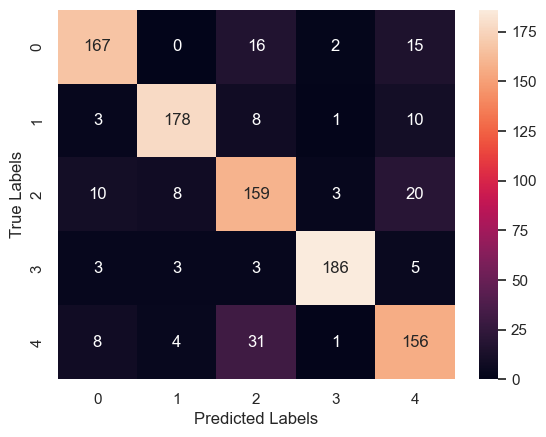

In [123]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_mlp_random)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

In [118]:
# results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_mlp_random)
# results_example

In [124]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_mlp_random))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       200
           1       0.92      0.89      0.91       200
           2       0.73      0.80      0.76       200
           3       0.96      0.93      0.95       200
           4       0.76      0.78      0.77       200

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



### Model 2: Random Forest Model

### Model 3: Multi Layer Perceptron (MLP)

In [115]:
%%time

# Parametre Values for MLP Model
mlp_param_dist = {'hidden_layer_sizes': [(5, ), (10, ), (15, )],
                  'activation': ['logistic', 'tanh', 'relu'],
                  'solver': ['sgd',],
                  'learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'max_iter': [100, 150, 200],
                  'batch_size': [16, 32, 64, X_train.shape[0]],
                  'alpha': [1e-4, 1e-3, 1e-2],
                 }

# MLP Model
mlp_clf = MLPClassifier()

# Multilayer Perceptron Model with Random Search
mlp_random_model = RandomizedSearchCV(estimator=mlp_clf,
                                      param_distributions=mlp_param_dist,
                                      n_iter=10,
                                      cv=kf,
                                      scoring='accuracy',
                                      random_state=23)

mlp_model = mlp_random_model.fit(X_train, y_train)

mlp_random_model_best_estimator = mlp_model.best_estimator_
mlp_random_model_best_params = mlp_model.best_params_
mlp_random_model_best_score = mlp_model.best_score_

# Model Performans Evaluate
mlp_random_scores = cross_val_score(mlp_random_model_best_estimator, X_train, y_train, cv=kf, scoring='accuracy')

means = mlp_model.cv_results_['mean_test_score']
stds = mlp_model.cv_results_['std_test_score']
params = mlp_model.cv_results_['params']

print("Id", "  Mean", "    StDev", "\t\t\t\t\tParam")
for idx, (mean, stdev, param) in enumerate(zip(means, stds, params)):
    print("%d %f (%f) with: %r" % (idx+1, mean, stdev, param))

# print()
# print("MLP Model with Random Search Best Parameters:", mlp_random_model_best_params)
# print("MLP Model with RandomSearch Accuracy: {:.3f}".format(mlp_random_scores.mean()))

# summarize results
print()
print("Best: %f using %s" % (mlp_random_model_best_score, mlp_random_model_best_params));print()

Id   Mean     StDev 					Param
1 0.817231 (0.008463) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'constant', 'hidden_layer_sizes': (10,), 'batch_size': 16, 'alpha': 0.001, 'activation': 'tanh'}
2 0.201692 (0.010256) with: {'solver': 'sgd', 'max_iter': 200, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.01, 'activation': 'logistic'}
3 0.194308 (0.003285) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (10,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'logistic'}
4 0.794923 (0.010396) with: {'solver': 'sgd', 'max_iter': 150, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'tanh'}
5 0.732154 (0.015609) with: {'solver': 'sgd', 'max_iter': 100, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (5,), 'batch_size': 32, 'alpha': 0.001, 'activation': 'relu'}
6 0.725538 (0.014832) with: {'solver': 'sgd', 'max_iter': 100, 'learning_r

In [116]:
%%time
y_pred_mlp_random = mlp_random_model_best_estimator.predict(X_test)

CPU times: total: 0 ns
Wall time: 3.93 ms


Text(47.25, 0.5, 'True Labels')

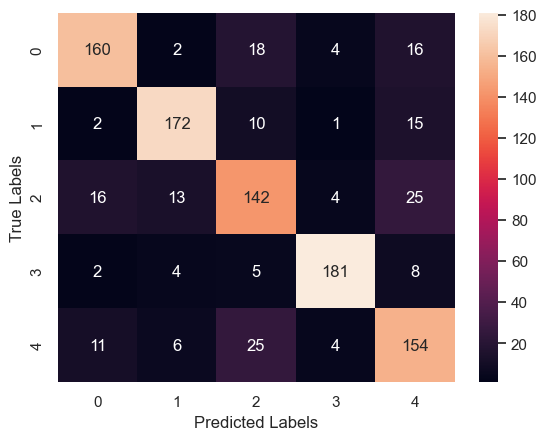

In [117]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_mlp_random)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

In [118]:
# results_example = evaluate_classification(y_true=y_test, y_pred=y_pred_mlp_random)
# results_example

In [83]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_mlp_random))

Classification Report:
              precision    recall  f1-score   support

       Dünya       0.81      0.81      0.81       200
      Eğitim       0.89      0.87      0.88       200
      Gündem       0.69      0.70      0.69       200
        Spor       0.93      0.92      0.92       200
     Türkiye       0.73      0.76      0.74       200

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



In [119]:
print("Classification Report:")
print(classification_report(y_true=y_test, y_pred=y_pred_mlp_random))

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       200
           1       0.87      0.86      0.87       200
           2       0.71      0.71      0.71       200
           3       0.93      0.91      0.92       200
           4       0.71      0.77      0.74       200

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000

